# Tarea Modelos de clasificación 

Diego Lozoya Morales | 745345

# Paqueterías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn import neighbors
from sklearn import discriminant_analysis
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

# Funciones

In [2]:
def histograma(probabilidades, y_test):
     df = pd.DataFrame({
     'real': y_test,
     'probabilidades': probabilidades
     })

     plt.figure(figsize=(10, 5))
     plt.hist(df[df.real == 1]['probabilidades'], density=True, color=colors[0], alpha=0.5, label = '1')
     plt.hist(df[df.real == 0]['probabilidades'], density=True, color=colors[1], alpha=0.5, label = '0')
     plt.title(f'Histograma de probabilidades')
     plt.xlabel("Probabilidad")
     plt.ylabel(" ")
     plt.legend()
     plt.show()

def calibracion(probabilidades, y_test):
    df_calibracion = pd.DataFrame({
        'probabilidades':probabilidades,
        'y':y_test
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['probabilidades'], q=15, labels=False)+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.figure(figsize=(10, 5))
    plt.plot(grouped.probabilidades, grouped.y, label="Modelo", marker="o", color=colors[0])
    plt.plot(grouped.probabilidades, grouped.probabilidades, label="Real", marker="o", color=colors[1])
    plt.xlabel("Probabilidad")
    plt.ylabel("Real")
    plt.title("Calibración")
    plt.grid()
    plt.legend()
    plt.show()

def roc(probabilidades, y_test):
     fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
     plt.figure(figsize=(10, 5))
     plt.plot(fpr, fnp, color=colors[0], lw=2)
     plt.plot([0, 1], [0, 1], color=colors[1], linestyle='--', lw=2, label='Clasificador aleatorio')
     plt.xlabel('1 - Specificity')
     plt.ylabel('Sensitivity')
     plt.title('ROC curve')
     plt.grid()
     plt.legend()
     plt.show()

def logistic(X_train, X_test, y_train, y_test):
     model = linear_model.LogisticRegression().fit(X_train, y_train)
     probabilidades = model.predict_proba(X_test)[:, 1]
     auc = roc_auc_score(y_score=probabilidades, y_true=y_test)
     gini = 2*auc - 1

     calibracion(probabilidades, y_test)
     roc(probabilidades, y_test)
     histograma(probabilidades, y_test)

     coeficientes = pd.DataFrame({
          'features': X_train.columns,
          'coeficiente': model.coef_[0]
     })
     display(coeficientes)

     print('Features que más propician el alzheimer:')
     display(coeficientes.sort_values('coeficiente', ascending=False).head(3))
     print('\nFeatures que más disminuyen el alzheimer:')
     display(coeficientes.sort_values('coeficiente', ascending=True).head(3))

     return print(f'AUC: {auc:.4f}\nGini: {gini:.4f}')

def logistic_poly(X_train, X_test, y_train, y_test, degree):
     pipeline = Pipeline([
          ('scaler', StandardScaler()),
          ('poly', PolynomialFeatures(degree=degree)),
          ('logistic', linear_model.LogisticRegression(penalty='l2'))
     ])

     pipeline.fit(X_train, y_train)
     probabilidades = pipeline.predict_proba(X_test)[:, 1]
     auc = roc_auc_score(y_score=probabilidades, y_true=y_test)
     gini = 2*auc - 1

     calibracion(probabilidades, y_test)
     roc(probabilidades, y_test)
     histograma(probabilidades, y_test)

     return print(f'AUC: {auc:.4f}\nGini: {gini:.4f}')

def knn(X_train, X_test, y_train, y_test, range_neighbors):
     scaler = StandardScaler()
     X_train_scaled = scaler.fit_transform(X_train)
     X_test_scaled = scaler.transform(X_test)

     neighbor = []
     auc = []
     for i in range(1, range_neighbors):
          model = neighbors.KNeighborsClassifier(n_neighbors=i).fit(X_train_scaled, y_train)
          probabilidades = model.predict_proba(X_test_scaled)[:, 1]
          neighbor.append(i)
          auc.append(roc_auc_score(y_score=probabilidades, y_true=y_test))

     resultados = pd.DataFrame({'auc': auc, 'neighbors': neighbor})

     nn_opt = resultados[resultados.auc == max(resultados.auc)].neighbors.values[0]

     plt.figure(figsize=(15, 5))
     plt.plot(resultados.neighbors, resultados.auc, label='Real', color=colors[0], marker='o')
     plt.scatter(nn_opt, max(resultados.auc), label=f'Óptimo neighbors = {nn_opt}', color=colors[1], s=50, zorder=10)
     plt.text(nn_opt, max(resultados.auc), f"Máximo AUC", va='bottom')
     plt.grid()
     plt.legend()
     plt.title("AUC by neighbors")
     plt.xlabel("Neighbors")
     plt.ylabel("AUC")
     plt.show()

     pipeline = Pipeline([
     ('scaler', StandardScaler()),
     ('logistic', neighbors.KNeighborsClassifier(n_neighbors=nn_opt))
     ])

     pipeline.fit(X_train, y_train)
     probabilidades = pipeline.predict_proba(X_test)[:, 1]
     auc = roc_auc_score(y_score=probabilidades, y_true=y_test)
     gini = 2*auc - 1

     calibracion(probabilidades, y_test)
     roc(probabilidades, y_test)
     histograma(probabilidades, y_test)
     
     return print(f'Con {nn_opt} neighbors:\n- AUC: {auc:.4f}\n- Gini: {gini:.4f}')

def discriminant(X_train, X_test, y_train, y_test):
     pipeline = Pipeline([
     ('scaler', StandardScaler()),
     ('logistic', discriminant_analysis.LinearDiscriminantAnalysis())
     ])

     pipeline.fit(X_train, y_train)
     probabilidades = pipeline.predict_proba(X_test)[:, 1]
     auc = roc_auc_score(y_score=probabilidades, y_true=y_test)
     gini = 2*auc - 1

     calibracion(probabilidades, y_test)
     roc(probabilidades, y_test)
     histograma(probabilidades, y_test)

     return print(f'AUC: {auc:.4f}\nGini: {gini:.4f}')

# Data

In [3]:
data = pd.read_csv('data/alzheimers_disease_data.csv')
data = data.drop(columns=['DoctorInCharge','PatientID'])
data = pd.get_dummies(data, columns=['Ethnicity','EducationLevel'])
data.head()

,Age,Gender,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,...,Forgetfulness,Diagnosis,Ethnicity_0,Ethnicity_1,Ethnicity_2,Ethnicity_3,EducationLevel_0,EducationLevel_1,EducationLevel_2,EducationLevel_3
0,73,0,22.927749,0,13.297218,6.327112,1.347214,9.025679,0,0,...,0,0,True,False,False,False,False,False,True,False
1,89,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,0,0,...,1,0,True,False,False,False,True,False,False,False
2,73,0,17.795882,0,19.555085,7.844988,1.826335,9.673574,1,0,...,0,0,False,False,False,True,False,True,False,False
3,74,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,0,0,...,0,0,True,False,False,False,False,True,False,False
4,89,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,0,0,...,0,0,True,False,False,False,True,False,False,False


## Variable dependiente

In [4]:
target = 'Diagnosis'
y = data[target]

## Cross validation

In [5]:
X = data.copy().drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Regresión logística

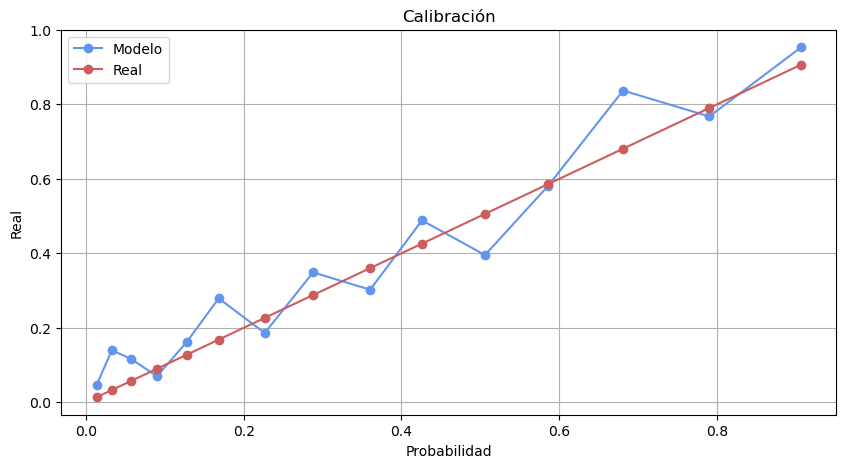

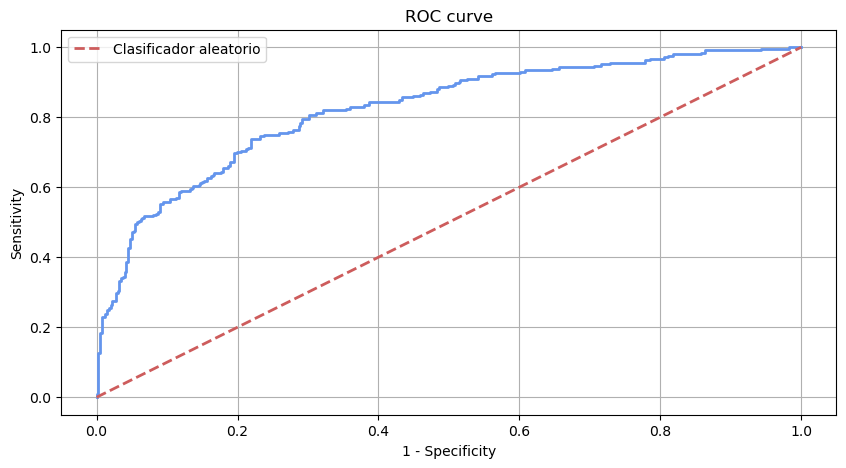

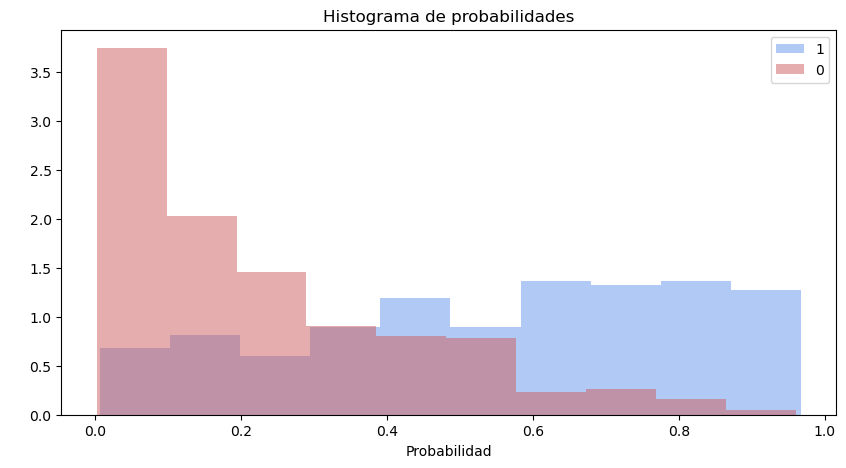

,features,coeficiente
0,Age,0.017198
1,Gender,0.134709
2,BMI,-0.018805
3,Smoking,-0.017405
4,AlcoholConsumption,-0.041112
5,PhysicalActivity,-0.029838
6,DietQuality,0.068912
7,SleepQuality,-0.095315
8,FamilyHistoryAlzheimers,-0.023929
9,CardiovascularDisease,0.066169


Features que más propician el alzheimer:


,features,coeficiente
22,MemoryComplaints,0.914171
23,BehavioralProblems,0.609267
1,Gender,0.134709



Features que más disminuyen el alzheimer:


,features,coeficiente
21,FunctionalAssessment,-0.359454
24,ADL,-0.293209
31,Ethnicity_1,-0.121615


AUC: 0.8233
Gini: 0.6465


In [6]:
logistic(X_train, X_test, y_train, y_test)

Sobre los coeficientes de la regresión logística se puede determinar que los 3 factores que más propician el Alzheimer son:
- Quejas sobre la memoria (0.9142)
- Problemas de comportamiento (0.6093)
- Género (0.1347)

Se puede ver que los factores que más afectan son las quejas sobre la memoria y los problemas de comportomiento, ya que tienen coeficientes muy altos. Aunque el género está en tercer lugar su coeficiente es considerablemente menor al de los otros 2.

Por otra parte los 3 coeficientes de la regresión logística que más disminuyen el Alzheimer son:
- Functional assessment (-0.3595)
- ADL (-0.2932)
- Ethnicity_1 (-0.1216)

# Polinomial

## Grado 2

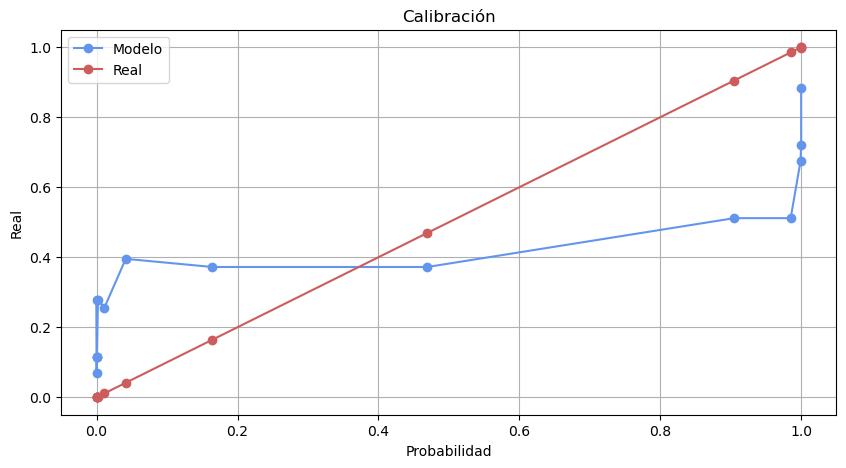

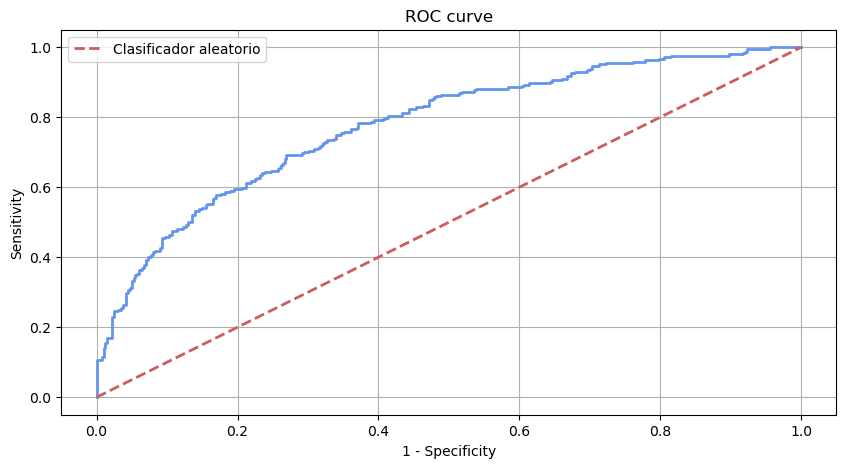

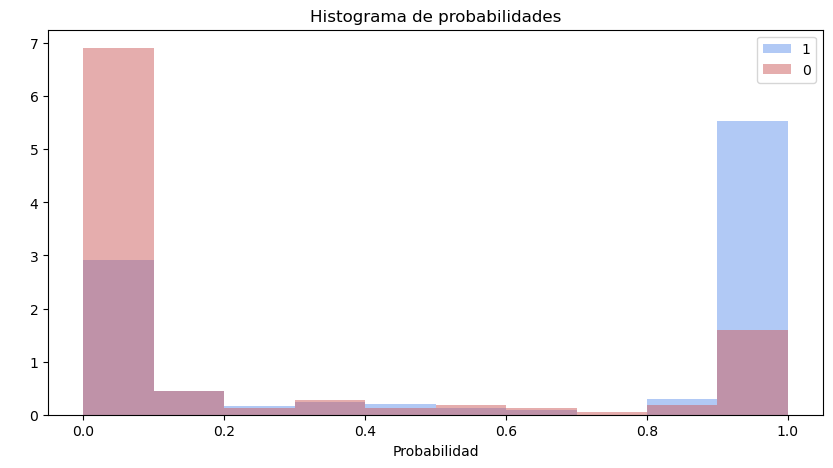

AUC: 0.7774
Gini: 0.5549


In [7]:
logistic_poly(X_train, X_test, y_train, y_test, 2)

## Grado 3

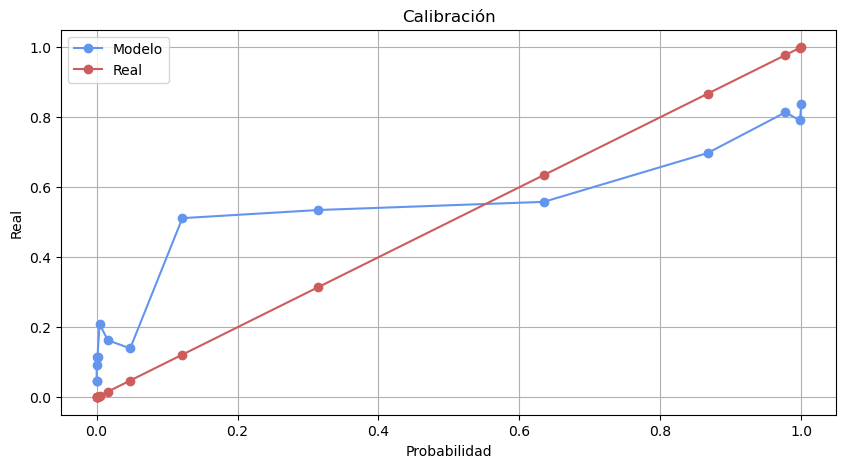

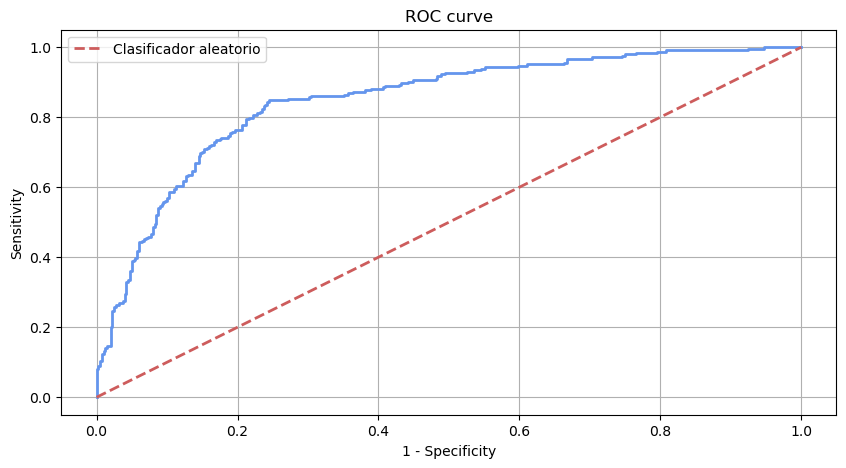

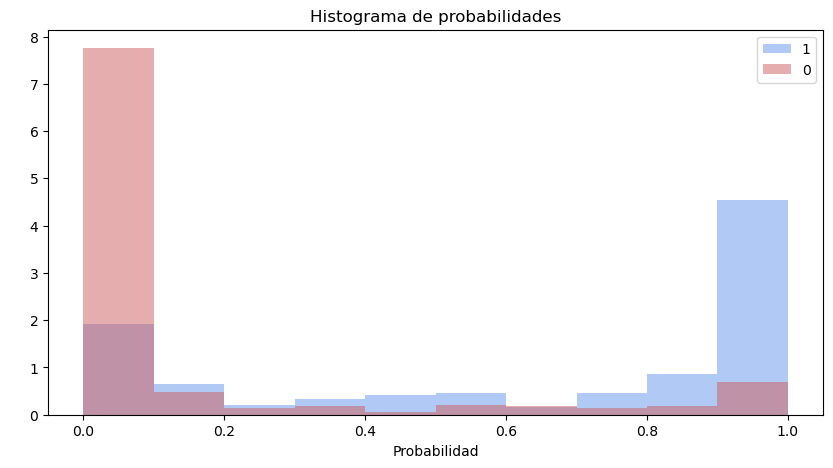

AUC: 0.8480
Gini: 0.6961


In [8]:
logistic_poly(X_train, X_test, y_train, y_test, 3)

# KNN

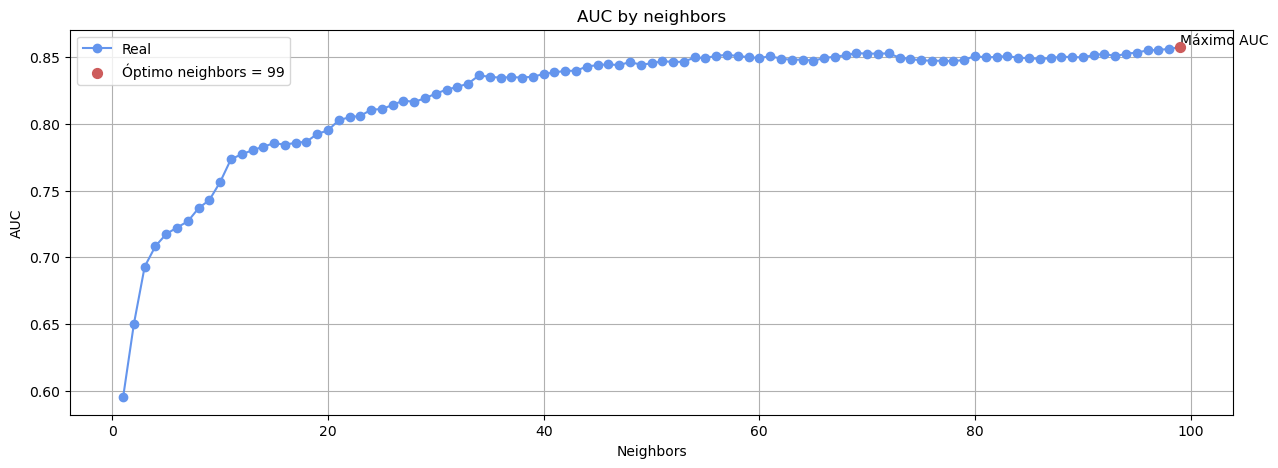

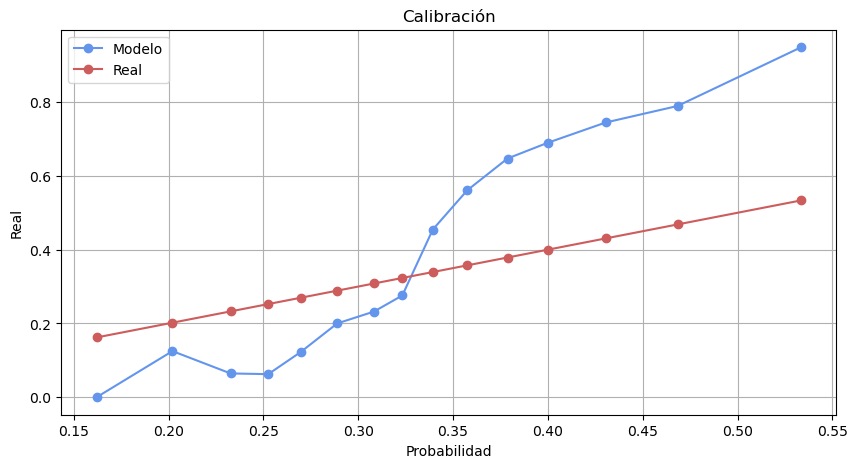

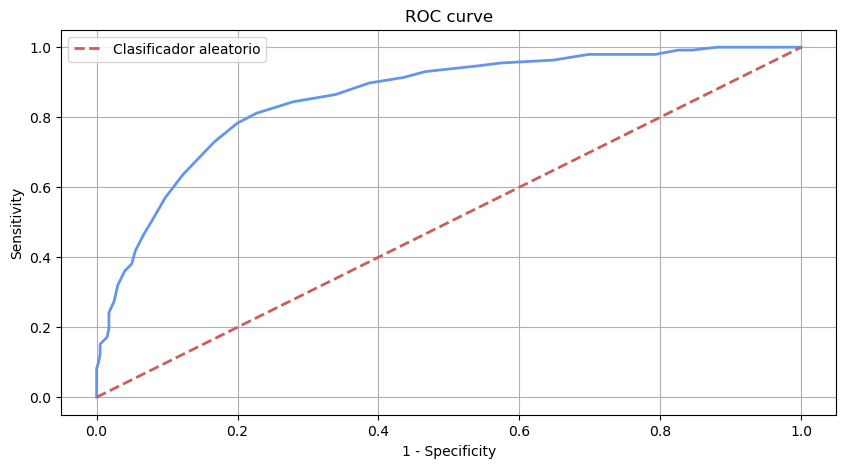

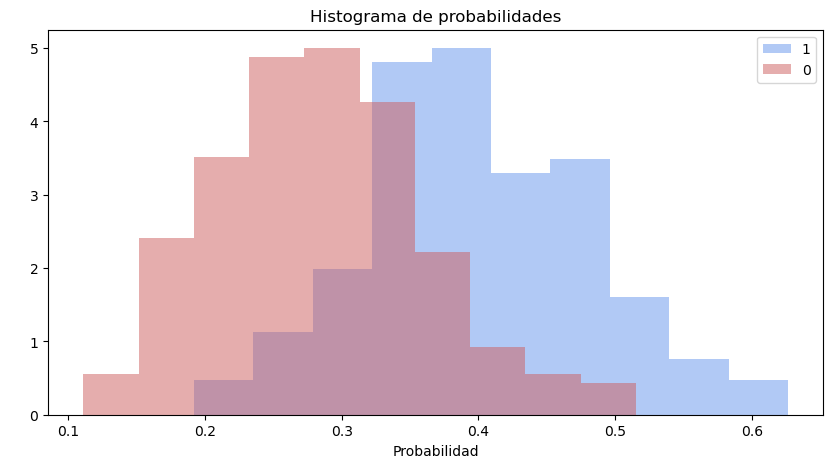

Con 99 neighbors:
- AUC: 0.8574
- Gini: 0.7148


In [9]:
knn(X_train, X_test, y_train, y_test, 100)

# Discriminante lineal

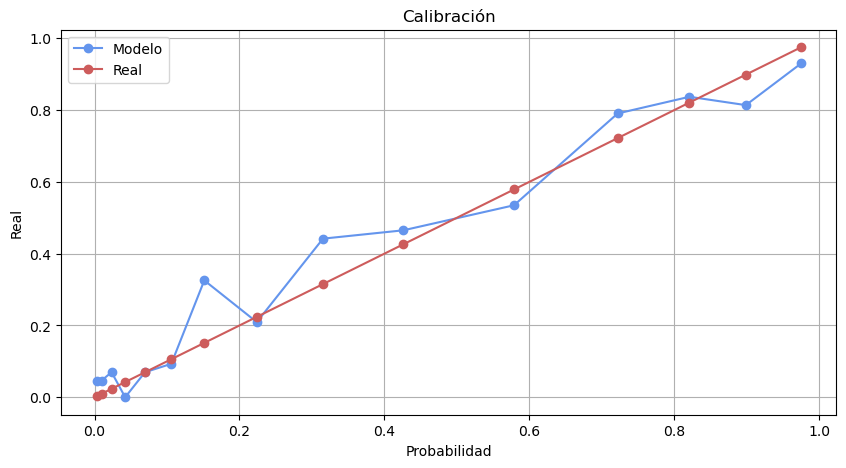

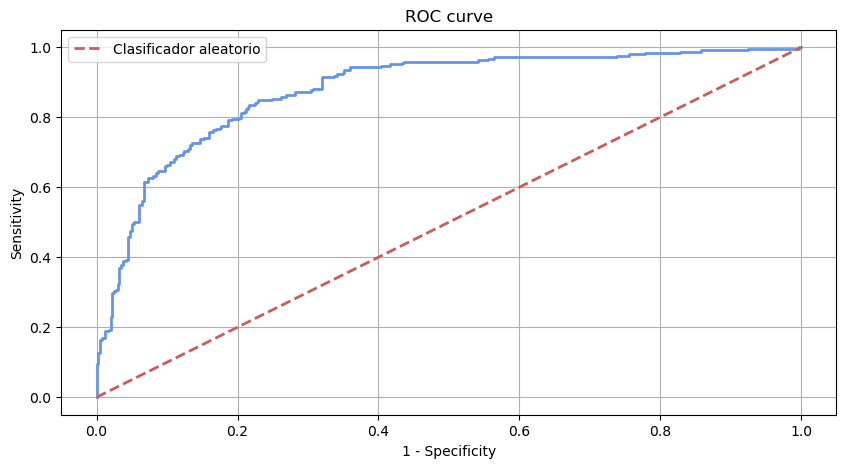

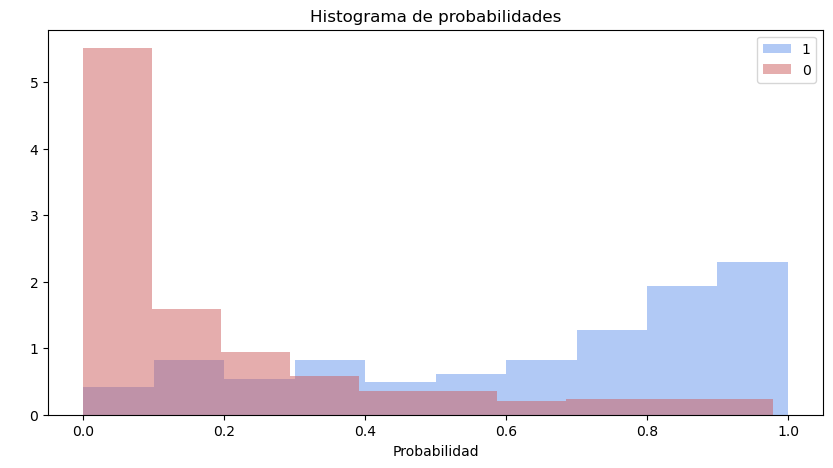

AUC: 0.8795
Gini: 0.7591


In [10]:
discriminant(X_train, X_test, y_train, y_test)

# Conclusiones

Tras haber hecho regresiones con el modelo logístico, polinomial grados 2 y 3, KNN y Discriminante lineal, sobre los datos del Alzheimer, se puede ver que el que mejor ajuste tuvo, es el modelo del discriminante lineal, con un valor de AUC de 0.8795. Este valor indica que en el 87.95% de las veces el modelo logrará predecir con éxito el Alzheimer de una persona, con base en todos los parámetros dados. Este modelo cuenta con un Gini de 0.7591, el cual indica que tiene una capacidad de discriminación del 75.91% al diferenciar correctamente entre personas con y sin Alzheimer.

El modelo de KNN, tras una prueba de 100 iteraciones, ha encontrado que el número óptimo de vecinos encontrados es de 99. Sin embargo, el modelo KNN con K=99 obtiene un AUC de únicamente 0.8574, el cual es menor al obtenido por el modelo de discriminante lineal.